<a href="https://colab.research.google.com/github/Howuhh/dul_2021/blob/hw3/Homework/hw3/Homework3_autoregressive_flows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone --single-branch https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 180, done.
remote: Counting objects: 100% (180/180), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 180 (delta 78), reused 133 (delta 49), pack-reused 0
Receiving objects: 100% (180/180), 28.64 MiB | 27.59 MiB/s, done.
Resolving deltas: 100% (78/78), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=15097 sha256=c6391520d175dfe398cc7d1e83bc9efc60cbf6f6670b8a4c30b36cbb1a16b2cc
  Stored in directory: /tmp/pip-ephem-wheel-cache-e4ugkv4c/wheels/55/59/29/0fb1c63565215773

In [2]:
from dul_2021.utils.hw3_utils import *


# Question 1: Autoregressive Flows for Images

Adapt your PixelCNN implementation from Homework 2 and use it as an autoregressive flow model on the black-and-white shapes dataset. Using the base architecture from Homework 2 1(a), output a mixture of logistics or gaussians (instead of logits), whose CDF we will use as our flow for each dimension of x. 

Remember: you must dequantize the data and scale it between 0 and 1 for the autoregressive flow to have stable training. 

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. **Make sure to account for any rescaling you do in your nats/dim.**
2.   Report the final test set performance of your final model
3. 100 samples from your autoregressive flow. Our plotting code will show your samples, with and without clipping and flooring (to remove the quantization). 


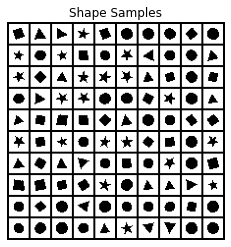

In [3]:
visualize_q1_data()


### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [36]:
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from scipy.optimize import bisect
from torch.distributions import Normal, Uniform

from tqdm.auto import trange, tqdm
from torch.utils.data import TensorDataset, DataLoader

def device(force_cpu=False):
    return "cuda" if torch.cuda.is_available() and not force_cpu else "cpu"


class MaskedConv2d(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.set_mask()

    def _set_independent_mask(self, typeB=0):  # type = {0: A, 1: B}
        h, w = self.kernel_size
        self.mask[:, :, h // 2, : w // 2 + typeB] = 1
        self.mask[:, :, :h // 2] = 1

    def forward(self, x, cond=None):
        return F.conv2d(x, self.mask * self.weight, bias=self.bias, stride=self.stride, padding=self.padding)

    def set_mask(self):
        raise NotImplementedError

class ConvA(MaskedConv2d):
    def set_mask(self):
        self._set_independent_mask(typeB=False)

class ConvB(MaskedConv2d):
    def set_mask(self):
        self._set_independent_mask(typeB=True)


class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        hidden_channels = in_channels // 2
        self.model = nn.Sequential(
            nn.ReLU(),
            ConvB(in_channels=in_channels, out_channels=hidden_channels, kernel_size=1),
            nn.ReLU(),
            ConvB(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=7, padding=3),
            nn.ReLU(),
            ConvB(in_channels=hidden_channels, out_channels=in_channels, kernel_size=1),
        )
    
    def forward(self, x):
        return x + self.model(x)


class FlowPixelCNN(nn.Module):
    def __init__(self, hidden_channels=120, num_blocks=8, num_heads=4):
        super().__init__()
        self.hidden_channels = hidden_channels
        self.num_blocks = num_blocks
        self.num_heads = num_heads

        self.base_dist = Uniform(torch.FloatTensor([0]).to(device()), torch.FloatTensor([1]).to(device()))

        model = [ConvA(1, self.hidden_channels, kernel_size=7, padding=3)]
        for _ in range(self.num_blocks):
          model.extend([nn.ReLU(), ResidualBlock(self.hidden_channels)])
        model.extend([nn.ReLU(), ConvB(self.hidden_channels, self.hidden_channels, kernel_size=1)])
        model.extend([nn.ReLU(), ConvB(self.hidden_channels, 3 * num_heads, kernel_size=1)])        
        self.model = nn.Sequential(*model)

    def forward(self, x):
        b, c, h, w = x.shape
        assert c == 1, "only 1 channel imgs"
        return self.model(x).view(b, 3 * self.num_heads, c, h, w)

    def flow(self, x, return_dist=False):
        alpha, mu, log_sigma = torch.chunk(self.forward(x), 3, dim=1)

        alpha = F.softmax(alpha, dim=1)
        dist = Normal(mu, log_sigma.exp())

        if return_dist:
            return alpha, dist

        x = x.unsqueeze(1).repeat(1, self.num_heads, 1, 1, 1)

        z = (dist.cdf(x) * alpha).sum(dim=1)
        log_det = (dist.log_prob(x).exp() * alpha).sum(dim=1).log()

        return z, log_det

    def _loss(self, batch):
        z, log_det = self.flow(batch)
        return -(self.base_dist.log_prob(z) + log_det).mean()

    @torch.no_grad()
    def test(self, test_dataloader):
        self.eval()
        losses = []
        for batch in tqdm(test_dataloader, desc="Testing", leave=False):
            batch = batch[0].to(device())
            loss = self._loss(batch)
            losses.append(loss.item())
        self.train()
        return np.mean(losses)

    def fit(self, train_dataloader, test_dataloader, epochs=20, lr=1e-3, clip_grad=None):
        optim = torch.optim.Adam(self.parameters(), lr=lr)

        loss_info = {"train": [], "test": [self.test(test_dataloader)]}
        for epoch in trange(epochs, desc="Training"):
            losses = []
            for batch in tqdm(train_dataloader, desc="Batches", leave=False):
                batch = (batch[0] / 2.0).to(torch.float) + torch.as_tensor(np.random.uniform(high=0.5, size=batch[0].shape), dtype=torch.float)
                batch = batch.to(device())

                loss = self._loss(batch)
                losses.append(loss.item())

                optim.zero_grad()
                loss.backward()
                if clip_grad is not None:
                    torch.nn.utils.clip_grad_norm_(self.parameters(), clip_grad)
                optim.step()

            loss_info["train"].append(np.mean(losses))
            loss_info["test"].append(self.test(test_dataloader))

        loss_info["train"] = np.array(loss_info["train"])
        loss_info["test"] = np.array(loss_info["test"])

        return loss_info

    @torch.no_grad()
    def inverse_flow_ij(self, hi, wj, zi, prev_x):
        alpha, dist = self.flow(prev_x, return_dist=True)

        prev_x = prev_x.unsqueeze(1).repeat(1, self.num_heads, 1, 1, 1).clone()

        def f(x):
            prev_x[..., hi, wj] = x
            return (dist.cdf(prev_x) * alpha).sum(dim=1)[0, 0, hi, wj] - zi

        new_x = bisect(f, -20, 20)
        
        return new_x

    @torch.no_grad()
    def sample(self, seed=None):
        if seed is not None:
            torch.manual_seed(seed)

        z = self.base_dist.sample((20, 20)).to(device())
        x = torch.zeros((1, 1, 20, 20)).to(device())

        for h in range(20):
            for w in range(20):
                x[0, 0, h, w] = self.inverse_flow_ij(h, w, z[h, w], x)
        
        return torch.clip(x, 0, 1).cpu().numpy().transpose(0, 2, 3, 1)

In [49]:
test_data = torch.ones((32, 1, 20, 20))
# test_model = FlowPixelCNN()
# test_model.to(device());
# test_model.flow(test_data)
# img = test_model.sample()

test_model = torch.load("model.pt")
img = test_model.sample()

In [54]:
def q1(train_data, test_data):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  H = W = 20
  Note that you should dequantize your train and test data, your dequantized pixels should all lie in [0,1]

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in [0, 1], where [0,0.5] represents a black pixel
      and [0.5,1] represents a white pixel. We will show your samples with and without noise. 
  """
  
  """ YOUR CODE HERE """
  torch.manual_seed(12)
  random.seed(12)
  np.random.seed(12)

  test_data = (test_data.astype(np.float32) / 2.0) + np.random.uniform(high=0.5, size=test_data.shape)

  test_data = TensorDataset(torch.FloatTensor(test_data.transpose(0, 3, 1, 2)))
  train_data = TensorDataset(torch.FloatTensor(train_data.transpose(0, 3, 1, 2)))

  test_dataloader = DataLoader(test_data, batch_size=128, shuffle=False, pin_memory=True)
  train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True, pin_memory=True)

  model = FlowPixelCNN(num_heads=15).to(device())
  loss_info = model.fit(train_dataloader, test_dataloader, epochs=20, lr=1e-3)

  imgs = np.vstack([model.sample() for _ in trange(100)]) 

  return loss_info["train"] + np.log(2), loss_info["test"] + np.log(2), imgs

### Results

Once you've implemented `q1`, execute the cells below to visualize and save your results



Testing:   0%|          | 0/36 [00:00<?, ?it/s]

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/82 [00:00<?, ?it/s]

Testing:   0%|          | 0/36 [00:00<?, ?it/s]

Batches:   0%|          | 0/82 [00:00<?, ?it/s]

Testing:   0%|          | 0/36 [00:00<?, ?it/s]

Batches:   0%|          | 0/82 [00:00<?, ?it/s]

Testing:   0%|          | 0/36 [00:00<?, ?it/s]

Batches:   0%|          | 0/82 [00:00<?, ?it/s]

Testing:   0%|          | 0/36 [00:00<?, ?it/s]

Batches:   0%|          | 0/82 [00:00<?, ?it/s]

Testing:   0%|          | 0/36 [00:00<?, ?it/s]

Batches:   0%|          | 0/82 [00:00<?, ?it/s]

Testing:   0%|          | 0/36 [00:00<?, ?it/s]

Batches:   0%|          | 0/82 [00:00<?, ?it/s]

Testing:   0%|          | 0/36 [00:00<?, ?it/s]

Batches:   0%|          | 0/82 [00:00<?, ?it/s]

Testing:   0%|          | 0/36 [00:00<?, ?it/s]

Batches:   0%|          | 0/82 [00:00<?, ?it/s]

Testing:   0%|          | 0/36 [00:00<?, ?it/s]

Batches:   0%|          | 0/82 [00:00<?, ?it/s]

Testing:   0%|          | 0/36 [00:00<?, ?it/s]

Batches:   0%|          | 0/82 [00:00<?, ?it/s]

Testing:   0%|          | 0/36 [00:00<?, ?it/s]

Batches:   0%|          | 0/82 [00:00<?, ?it/s]

Testing:   0%|          | 0/36 [00:00<?, ?it/s]

Batches:   0%|          | 0/82 [00:00<?, ?it/s]

Testing:   0%|          | 0/36 [00:00<?, ?it/s]

Batches:   0%|          | 0/82 [00:00<?, ?it/s]

Testing:   0%|          | 0/36 [00:00<?, ?it/s]

Batches:   0%|          | 0/82 [00:00<?, ?it/s]

Testing:   0%|          | 0/36 [00:00<?, ?it/s]

Batches:   0%|          | 0/82 [00:00<?, ?it/s]

Testing:   0%|          | 0/36 [00:00<?, ?it/s]

Batches:   0%|          | 0/82 [00:00<?, ?it/s]

Testing:   0%|          | 0/36 [00:00<?, ?it/s]

Batches:   0%|          | 0/82 [00:00<?, ?it/s]

Testing:   0%|          | 0/36 [00:00<?, ?it/s]

Batches:   0%|          | 0/82 [00:00<?, ?it/s]

Testing:   0%|          | 0/36 [00:00<?, ?it/s]

Batches:   0%|          | 0/82 [00:00<?, ?it/s]

Testing:   0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Final Test Loss: 0.0786


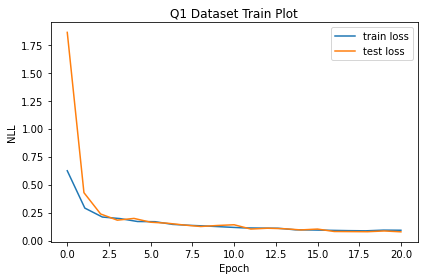

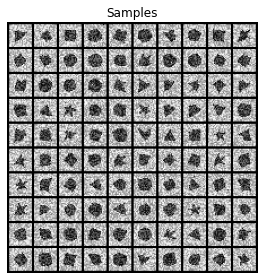

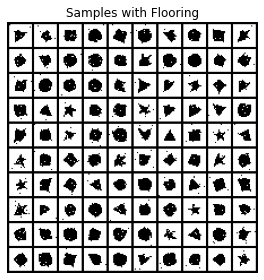

In [55]:
q1_save_results(q1)